In [1]:
# Load the python modules.
import os, sys
import numpy as np
import wget
from dapper import Chronology
#Insert the common folder in the path (to be able to load python module)
sys.path.insert(0,os.path.join(os.path.pardir,'common'))
from toolbox import load_config, path, get_filenames, load_data, rmse_norm
from l2s_utils import plot_L96_2D, default_param

Initializing DAPPER...

but is not supported by current backend: module://ipykernel.pylab.backend_inline.
Try another backend in your settings, e.g., mpl.use('Qt5Agg').
...Done
PS: Turn off this message in your configuration: dpr_config.ini


# Setting

## Source of the data
The variable ```source``` can be set to ```"ftp"``` or ```"local"```.
- ```ftp```: it will download the data from an ftp server, so there is no need to compute the data. WARNING: it will override existing data in the data simulations data directory.
- ```local```: it will load the data locally. So you have to first either having downloaded the data from the ftp server, either having computing the data using the other notebooks.

## Configuration files
There are 4 configuration file to set. Default configuration files are provided but if you want to make further experiment, it is possible to change the configuration file.
- ```config_path```: contains all the paths where to load and save the data.
- ```config_ftp```: contains the url of the data in the ftp server. This configuration file is optional if you don't download the data from ftp.
- ```config_ref```: contains the reference simulations settings.
- ```config_sens```: contains the different settings for an sensitivity experiment.

In [2]:
#Source of the data (comment/uncomment the lines given your choice)
source = 'local'
#source = 'ftp'


In [3]:
#Configuration files
config_path = 'config/paths.yml'
config_ftp = 'config/ftp.yml' #optional if data are generated locally
config_ref = 'config/ref.yml'
config_sens = 'config/sens.yml'

In [4]:
# Load the paths (yml file)
paths = load_config('config/paths.yml')

# Rootdir for the L2S data
rootdir = path(paths['rootdir'])

#Check if figdir exist and set the figdir accordingly
savefig = 'figdir' in paths and bool(paths['figdir'])
figdir = path(os.path.join(rootdir,paths['figdir'])) if savefig else None

#Directory containing the simulations
testdir = path(os.path.join(rootdir,paths['testdir']))

#Print:
print("Directory containing the simulations:\n->",testdir)
if figdir:
    print("Directory to save the figures:\n->",figdir)

Directory containing the simulations:
-> /Users/brajard/Documents/recherche/papers/2020/PHILTRA/reddaml/data/L2S/simul/test
Directory to save the figures:
-> /Users/brajard/Documents/recherche/papers/2020/PHILTRA/reddaml/data/L2S/fig


In [5]:
#Load the ftp configuration file if needed
if source == 'ftp':
    ftp = load_config(config_ftp)
    ftpurl, ftpdir = ftp['url'], ftp['test']
    print('\033[93m'+'Warning! The source is set to ftp. \nIt will override existing local simulation in the simulation directory'+'\033[0m')
else:
    ftp = None
    ftpurl, ftpdir = None, None

## Plot Figure 1

In [6]:
# Define the reference experiment to plot
ref = load_config(config_ref)
print('Parameters of the reference experiment:\n',ref['params'])
print('Template names used to load the reference experiment:\n',ref['files'])

Parameters of the reference experiment:
 {'p': [36], 'dtObs': [0.05], 'std_o': [0.1], 'Nfil_train': [1], 'T': [15]}
Template names used to load the reference experiment:
 {'truth': 'simul-truth-T{T}-N{N}-seed{seed}.npz', 'hybrid': 'simul-hybrid-p{p}-dtObs{dtObs}-std_o{std_o}-filter{Nfil_train}-N{N}-seed{seed}.npz'}


In [7]:
# Load the data of the hybrid/true run
filename = get_filenames(ref, default_param=default_param)

#Check if there is exactly one filename to load
assert len(filename['hybrid']) == 1

#Set the filename (as a str) of the data
fname = str(filename['truth'].name.iloc[0])
data_truth = load_data(testdir,fname,ftpurl=ftpurl,ftpdir=ftpdir)

print("Data file truth:\n->",fname)

fname = str(filename['hybrid'].name.iloc[0])
data_hybrid = load_data(testdir,fname,ftpurl=ftpurl,ftpdir=ftpdir)

print("Data file hybrid:\n->",fname)

Data file truth:
-> simul-truth-T15.0-N20-seed10.npz
Data file hybrid:
-> simul-hybrid-p36-dtObs0.05-std_o0.1-filter1-N20-seed10.npz


In [8]:
# Format the data (the time step of the hybrid model is different from the time step of the real model)

#hybrid data
xx_hybrid = data_hybrid['xx']

#chronology
chrono_hybrid = Chronology(dkObs=1,T=data_hybrid['T'],dt=data_hybrid['dt'])
chrono_truth = Chronology(dkObs=1,T=data_truth['T'],dt=data_truth['dt'])

#Compute the time step subsample:
dk = int(chrono_hybrid.dt/chrono_truth.dt)

#Compute the size of the hybrid model stat:
nU = xx_hybrid.shape[-1]

#Subsampe the true model in space and time to fit the hybrid model space
xx_truth = data_truth['xx'][::dk,:,:nU]

#Define the time axis
tt = chrono_hybrid.tt

#Display the size of the model simulations
print('Size of the time axis:',tt.shape)
print('Size of the truth simulation (time step, members, space):',xx_truth.shape)
print('Size of the hybrid simulation (time step, members, space):',xx_hybrid.shape)

Size of the time axis: (1501,)
Size of the truth simulation (time step, members, space): (1501, 20, 36)
Size of the hybrid simulation (time step, members, space): (1501, 20, 36)


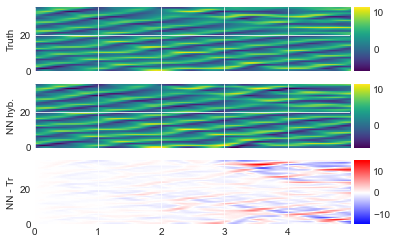

In [9]:
# Plot the figure 1

#Ensemble member to plot:
iens=1

#Number of time steps to plot
limT = 500

#Plot
fig = plot_L96_2D(xx_truth[:limT,iens],xx_hybrid[:limT,iens],tt[:limT],['Truth','NN hyb.'])

#Save (if needed)
if figdir:
    fig.savefig(os.path.join(figdir,'philtra-fig1.png'),
            dpi=200, bbox_inches='tight', pad_inches=0)

## Plot Figure 2

In [10]:
sens = load_config(config_sens)
print('Parameters of the sensitivity experiment:\n',sens['params'])
print('Template names used to load the reference experiment:\n',sens['files'])

#Reload ref file (in case you haven't been gone through Plot Figure 1)
ref = load_config(config_ref)

Parameters of the sensitivity experiment:
 {'p': [18, 27, 36], 'dtObs': [0.01, 0.05, 0.1, 0.15], 'std_o': [0.05, 0.1, 0.2, 0.5, 1.0, 2.0], 'Nfil_train': [1, 5], 'T': [15]}
Template names used to load the reference experiment:
 {'truth': 'simul-truth-T{T}-N{N}-seed{seed}.npz', 'hybrid': 'simul-hybrid-p{p}-dtObs{dtObs}-std_o{std_o}-filter{Nfil_train}-N{N}-seed{seed}.npz', 'trunc': 'simul-trunc-T{T}-N{N}-seed{seed}.npz', 'perfect': 'simul-perfect-dtObs{dtObs}-N{N}-seed{seed}.npz'}


In [11]:
# (Re)Load the data of the true/truncated run
filename = get_filenames(sens, default_param=default_param)

#Check if there is exactly one filename to load
assert len(filename['truth']) == 1

if source == 'ftp':
    ftpurl, ftpdir = ftp['url'], ftp['test']
else:
    ftpurl, ftpdir = None, None

#Set the filename (as a str) of the data
fname = str(filename['truth'].name.iloc[0])
data_truth = load_data(testdir,fname,ftpurl=ftpurl,ftpdir=ftpdir)

print("Data file truth:\n->",fname)

#Set the filename (as a str) of the data
fname = str(filename['trunc'].name.iloc[0])
data_trunc = load_data(testdir,fname,ftpurl=ftpurl,ftpdir=ftpdir)

print("Data file trunc:\n->",fname)

#Set the filename (as a str) of the data
fname = str(filename['perfect'].name.iloc[0])
data_perfect = load_data(testdir,fname,ftpurl=ftpurl,ftpdir=ftpdir)

print("Data file perfect:\n->",fname)

Data file truth:
-> simul-truth-T15.0-N20-seed10.npz
Data file trunc:
-> simul-trunc-T15.0-N20-seed10.npz
Data file perfect:
-> simul-perfect-dtObs0.01-N20-seed10.npz


In [12]:
# Format the data (the time step of the trunc model is different from the time step of the real model)


#Trunc data
xx_trunc = data_trunc['xx']

#chronology
chrono_trunc = Chronology(dkObs=1,T=data_trunc['T'],dt=data_trunc['dt'])
chrono_truth = Chronology(dkObs=1,T=data_truth['T'],dt=data_truth['dt'])

#Compute the time step subsample:
dk = int(chrono_trunc.dt/chrono_truth.dt)

#Compute the size of the trunc model stat:
nU = xx_trunc.shape[-1]

#Subsampe the true model in space and time to fit the trunc model space
xx_truth = data_truth['xx'][::dk,:,:nU]

#Define the time axis
tt = chrono_trunc.tt

#Display the size of the model simulations
print('Size of the time axis:',tt.shape)
print('Size of the truth simulation (time step, members, space):',xx_truth.shape)
print('Size of the trunc simulation (time step, members, space):',xx_trunc.shape)

Size of the time axis: (1501,)
Size of the truth simulation (time step, members, space): (1501, 20, 36)
Size of the trunc simulation (time step, members, space): (1501, 20, 36)


In [13]:
#Reformat DataFrame
import pandas as pd

#Add a column in the Data frame with the type of simulation
for k in filename:
    filename[k]=filename[k].assign(model=k)

#Concatenate all the dataframe in one:
df = pd.concat([v for k,v in filename.items()], ignore_index=True)
df

Nfil_train   T  dtObs   p  std_o  \
0             1  15   0.01  18   0.05   
1             1  15   0.01  18   0.05   
2             1  15   0.01  18   0.10   
3             1  15   0.01  18   0.20   
4             1  15   0.01  18   0.50   
..          ...  ..    ...  ..    ...   
145           1  15   0.01  18   0.05   
146           1  15   0.01  18   0.05   
147           1  15   0.05  18   0.05   
148           1  15   0.10  18   0.05   
149           1  15   0.15  18   0.05   

                                                  name    model  
0                     simul-truth-T15.0-N20-seed10.npz    truth  
1    simul-hybrid-p18-dtObs0.01-std_o0.05-filter1-N...   hybrid  
2    simul-hybrid-p18-dtObs0.01-std_o0.1-filter1-N2...   hybrid  
3    simul-hybrid-p18-dtObs0.01-std_o0.2-filter1-N2...   hybrid  
4    simul-hybrid-p18-dtObs0.01-std_o0.5-filter1-N2...   hybrid  
..                                                 ...      ...  
145                   simul-trunc-T15.0-N20-seed10.npz    trunc  
146             simul-perfect-dtObs0.01-N20-seed10.npz  perfect  
147             simul-perfect-dtObs0.05-N20-seed10.npz  perfect  
148              simul-perfect-dtObs0.1-N20-seed10.npz  perfect  
149             simul-perfect-dtObs0.15-N20-seed10.npz  perfect  

[150 rows x 7 columns]

In [ ]:
#Compute the RMSE between the hybrid simulation and the true simulation
RMSE = dict()

#Time to compute the RMSE
it = 200

df.assign(RMSE = np.nan) #Default value (changed in the loop)
print('->compute RMSE for the all the models (except the truth)')
for idx in df[df.model != 'truth'].index:
    fname = df.loc[idx,'name']
    data = load_data(testdir,fname,ftpurl=ftpurl,ftpdir=ftpdir)
    xx_est = data['xx']
    RMSE[idx] = rmse_norm(xx_truth,xx_est)
    df.loc[idx,'RMSE'] = RMSE[idx][it]
    data.close()


->compute RMSE for the all the models (except the truth)


In [ ]:
#Initialise the figure
import matplotlib.pyplot as plt
fig, (ax, ax0,ax1) = plt.subplots(ncols=3,figsize=(8.1,3),sharey='all')


#Plot the sensitivity to dtobs
df_dthyb = df[(df['Nfil_train']==ref_params['Nfil_train'][0])&
          (df['std_o']==ref_params['std_o'][0])&
          (df['p']==ref_params['p'][0]) & (df['model']=='hybrid')
         ]

df_dtpo = df[df['model']=='perfect']
df_trunc = df[df['model']=='trunc']

x = np.arange(df_dthyb.shape[0])
xtrunc = [len(x)]
ax0.bar(x=x-0.2,height=df_dthyb['RMSE'],width=0.4,color='C1',label='DA hyb.');
ax0.bar(x=x+0.2,height=df_dtpo['RMSE'],width=0.4,color='C2',label='perf.obs. hyb.');
ax0.bar(x=xtrunc,height=df_trunc['RMSE'],width=0.4,color='C3',label='trunc.')
ax0.set_xticks(list(x)+xtrunc);
ax0.set_xticklabels([str(dt) for dt in df_dthyb['dtObs']]+['trunc.']);
ax0.bar(x=x[1]-0.2,height=df_dthyb.iloc[1]['RMSE'],width=0.4,fill=False,LineWidth=2,edgecolor='black',label='ref.exp.')

ax0.legend()
ax0.set_xlabel('$\Delta t$')

#Plot the sensitivity to the filtration
df_filhyb = df_stdo = df[(df['dtObs']==ref_params['dtObs'][0]) & 
          (df['p']==ref_params['p'][0]) &
          (df['Nfil_train'].isin([1,5])) & (df['model']=='hybrid')
         ]
df_1 = df_filhyb[df_filhyb['Nfil_train']==1]
df_5 = df_filhyb[df_filhyb['Nfil_train']==5]


x = np.arange(df_1.shape[0])
ax1.bar(x=x-0.2,height=df_1['RMSE'],
        width=0.4,color='C1',label='no filter');
ax1.bar(x=x+0.2,height=df_5['RMSE'],
        width=0.4,color='C4',label='filter 0.05 MTU');
ax1.bar(x=x[1]-0.2,height=df_1.iloc[1]['RMSE'],
        width=0.4,fill=False,LineWidth=2,edgecolor='black',label='ref.exp.')
ax1.set_xticks(x);
ax1.set_xticklabels(['{}'.format(stdo) for stdo in df_1['std_o']]);
ax1.set_xlabel('$\sigma^o$')
ax1.legend()

#Plot the sensitivity to the density of observations (time series)
#Plot the sensitivity to dtobs

#Number time step to display
limT = 800

#Displayed color
cols=['C5','C6','C1']

df_phyb = df[(df['Nfil_train']==ref_params['Nfil_train'][0])&
          (df['std_o']==ref_params['std_o'][0])&
          (df['dtObs']==ref_params['dtObs'][0]) & 
             (df['model']=='hybrid')
         ]

df_ppo = df[(df['model']=='perfect') & 
            (df['dtObs']==ref_params['dtObs'][0])]

for i,idx in enumerate(df_phyb.index):
    ax.plot(tt[:limT],RMSE[idx][:limT],
            label='$N_y$={}'.format(df_phyb.loc[idx,'p']),
           color=cols[i])
ax.plot(tt[:limT],RMSE[df_trunc.index[0]][:limT],
        label='trunc.',color='C3',linewidth=2)

ax.plot(tt[:limT],RMSE[df_ppo.index[0]][:limT],
        label='perf. obs.',color='C2',linewidth=2)

ax.legend();

if figdir:
    fig.savefig(os.path.join(figdir,'philtra-fig2.png'),
            dpi=200, bbox_inches='tight', pad_inches=0)
